### REFERENCES

Text classification using neural network | google colab (2020) YouTube. Available at: https://www.youtube.com/watch?v=QE6-FMiRajQ (Accessed: 17 September 2023). 

Ahamed, S. (2018) Text classification using CNN, LSTM and visualize word embeddings: Part-2, Medium. Available at: https://sabber.medium.com/classifying-yelp-review-comments-using-cnn-lstm-and-visualize-word-embeddings-part-2-ca137a42a97d (Accessed: 17 September 2023). 

Alshammari, W.T. (2022) How to use Arabic word2vec word embedding with LSTM for sentiment analysis task, Medium. Available at: https://medium.com/@WaadTSS/how-to-use-arabic-word2vec-word-embedding-with-lstm-af93858b2ce (Accessed: 17 September 2023). 

Mikolov, T., Chen, K., Corrado, G. and Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. [online] arXiv.org. Available at: https://arxiv.org/abs/1301.3781.

www.youtube.com. (n.d.). Text Classification using LSTM on Amazon Review Dataset with TensorFlow 2.1 #nlp #tutorial. [online] Available at: https://www.youtube.com/watch?v=DUZn8hMLnbI [Accessed 17 Sep. 2023].

‌Analytics Vidhya. (2021). LSTM for Text Classification | Beginners Guide to Text Classification. [online] Available at: https://www.analyticsvidhya.com/blog/2021/06/lstm-for-text-classification/.

‌



‌

0


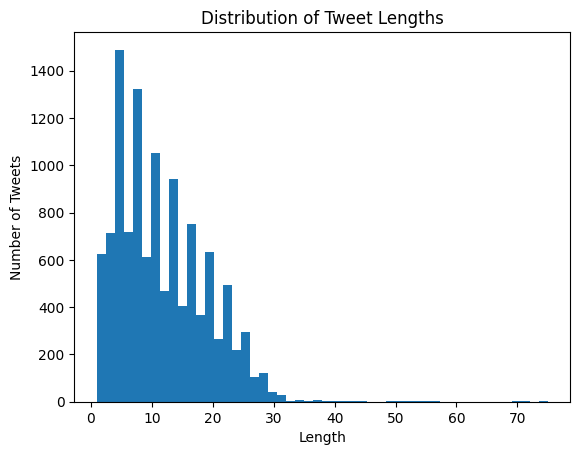

Average length: 11.622237392268964
Median length: 10.0
90th percentile length: 22.0


In [6]:
import pandas as pd
import gensim
import matplotlib.pyplot as plt

data = pd.read_csv('UseThisClean.csv')

# Convert labels to numerical categories if they aren't already
data['Class'] = data['Class'].astype('category').cat.codes

data = data.dropna(subset=['clean_text'])
print(data['clean_text'].isnull().sum())

# Calculate lengths
tweet_lengths = data['clean_text'].apply(lambda x: len(str(x).split()))

# Plot histogram
plt.hist(tweet_lengths, bins=50)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Tweets')
plt.show()

# Print some statistics
print("Average length:", tweet_lengths.mean())
print("Median length:", tweet_lengths.median())
print("90th percentile length:", tweet_lengths.quantile(0.90))


In [4]:
from gensim.models import Word2Vec

# Load AraVec model
model_path = 'full_grams_sg_100_twitter.mdl'
aravec = Word2Vec.load(model_path)

embedding_dim = aravec.vector_size


In [22]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_words = 10000  # Only consider top 10k words
max_len = 30  # Only consider the first 25 words of each tweet (Calculated average words of each tweet in previous cell)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['clean_text'])

sequences = tokenizer.texts_to_sequences(data['clean_text'])
word_index = tokenizer.word_index

# Pad sequences
X = pad_sequences(sequences, maxlen=max_len)
y = data['Class'].values

# Splitting data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        if word in aravec.wv:
          embedding_matrix[i] = aravec.wv[word]


In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM, GlobalMaxPooling1D, SpatialDropout1D
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization


model = Sequential()

vocab_size = 10000  # Consider top 10k words


# Embedding layer
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))

# Single LSTM layer with dropout
model.add(LSTM(64, dropout=0.5))

# Add dropout after LSTM to compensate for removed recurrent dropout
model.add(Dropout(0.5))


# Dense layer with Dropout (Reduced L2 regularization)
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# Final layer
model.add(Dense(3, activation='softmax'))

# Optimizer with reduced learning rate
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the early stopping criteria
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True, verbose=1)

# Adjusting Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 100)           1000000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 3)                 99        
                                                                 
Total params: 1,044,419
Trainable params: 1,044,419
No

Epoch 1/100
469/469 [==============================] - 21s 38ms/step - loss: 1.0975 - accuracy: 0.3713 - val_loss: 1.0568 - val_accuracy: 0.5115 - lr: 1.0000e-04
Epoch 2/100
469/469 [==============================] - 17s 35ms/step - loss: 1.0465 - accuracy: 0.4529 - val_loss: 0.9608 - val_accuracy: 0.6064 - lr: 1.0000e-04
Epoch 3/100
469/469 [==============================] - 17s 37ms/step - loss: 0.9495 - accuracy: 0.5296 - val_loss: 0.8344 - val_accuracy: 0.6384 - lr: 1.0000e-04
Epoch 4/100
469/469 [==============================] - 16s 35ms/step - loss: 0.8794 - accuracy: 0.5764 - val_loss: 0.7927 - val_accuracy: 0.6592 - lr: 1.0000e-04
Epoch 5/100
469/469 [==============================] - 16s 35ms/step - loss: 0.8379 - accuracy: 0.6040 - val_loss: 0.7702 - val_accuracy: 0.6677 - lr: 1.0000e-04
Epoch 6/100
469/469 [==============================] - 18s 37ms/step - loss: 0.8062 - accuracy: 0.6227 - val_loss: 0.7495 - val_accuracy: 0.6747 - lr: 1.0000e-04
Epoch 7/100
469/469 [=======

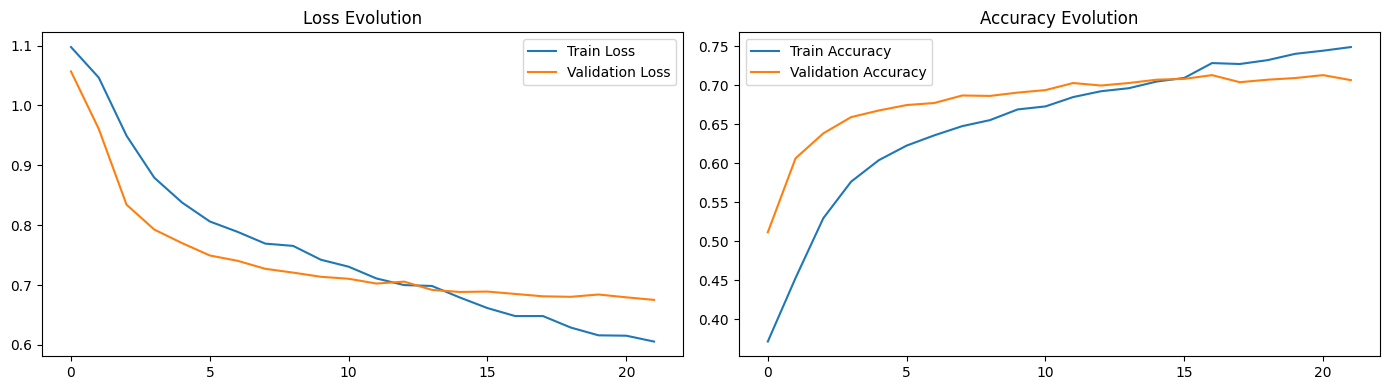

In [24]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, shuffle=True, callbacks=[early_stop, reduce_lr])

# Visualization of training process
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


74/74 [==============================] - 1s 8ms/step
Accuracy: 0.7244027303754266
Precision: 0.7299036630431174
Recall: 0.7279921547162926
F1 Score: 0.728875669582593
